In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from plotly.offline import plot
import seaborn as sns
from datetime import datetime, timedelta

sns.set_style("whitegrid")

In [170]:
# Loading up all data
df= pd.read_csv('habsos_20230714.csv',parse_dates=['SAMPLE_DATE'])

/var/folders/md/dkhh40ls43946rm74g11l2340000gn/T/ipykernel_41297/1109652745.py:2: DtypeWarning:

Columns (18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.



I will first focus on `Venice` and `Saratosa` area as they seem to have more consistent data.

In [171]:
# Try to focus on Venice and Saratosa area with LONGITUDE and LATITUDE (which seems to have data taken consistently).

df_ven_sar = df.loc[ (df.LONGITUDE < -82.38)&(-82.7683 < df.LONGITUDE )
              &( 26.96 < df.LATITUDE )&( df.LATITUDE <27.45 )]

For the time series application I will first consider only cell count and use all the data. As NaN values appear on the
other columns nothing needed to be droppped. Following lectures 6-7 I will try to do some `baseline forecasts` and `arima models`.


In [172]:
# The start and final dates of the data
print('The starting date of the data',df_ven_sar.SAMPLE_DATE.min())
print('The final date of the data',df_ven_sar.SAMPLE_DATE.max())

The starting date of the data 1953-09-03 00:00:00
The final date of the data 2023-06-26 15:50:00


In [173]:
# Here I take and monthly average of the data instead of working day by day.
month_av = []
for j in range(1953,2024):
    for i in range(1,13):
        month_av.append(df_ven_sar.loc[df_ven_sar.SAMPLE_DATE.dt.year == j].loc[df_ven_sar.loc[df_ven_sar.SAMPLE_DATE.dt.year == j].SAMPLE_DATE.dt.month == i].CELLCOUNT.mean())
    

Below we have the new monthly averaged dataframe. As some of the months have no readings they will appear as NaN so I also dropped them in the final step and called the dataframe as `df_monthly_nona` .

In [174]:
# making a new monthly averaged dataframe.
df_monthly = pd.DataFrame({'year_month': pd.date_range('1953-01', '2024-1', freq='M'),
                           'cellcount':month_av})
df_monthly_nona = df_monthly.dropna(ignore_index=True).copy()
df_monthly_nona['cellcount_log'] = np.log10(df_monthly_nona.cellcount.replace(0,1))

Below is the plot of all data.

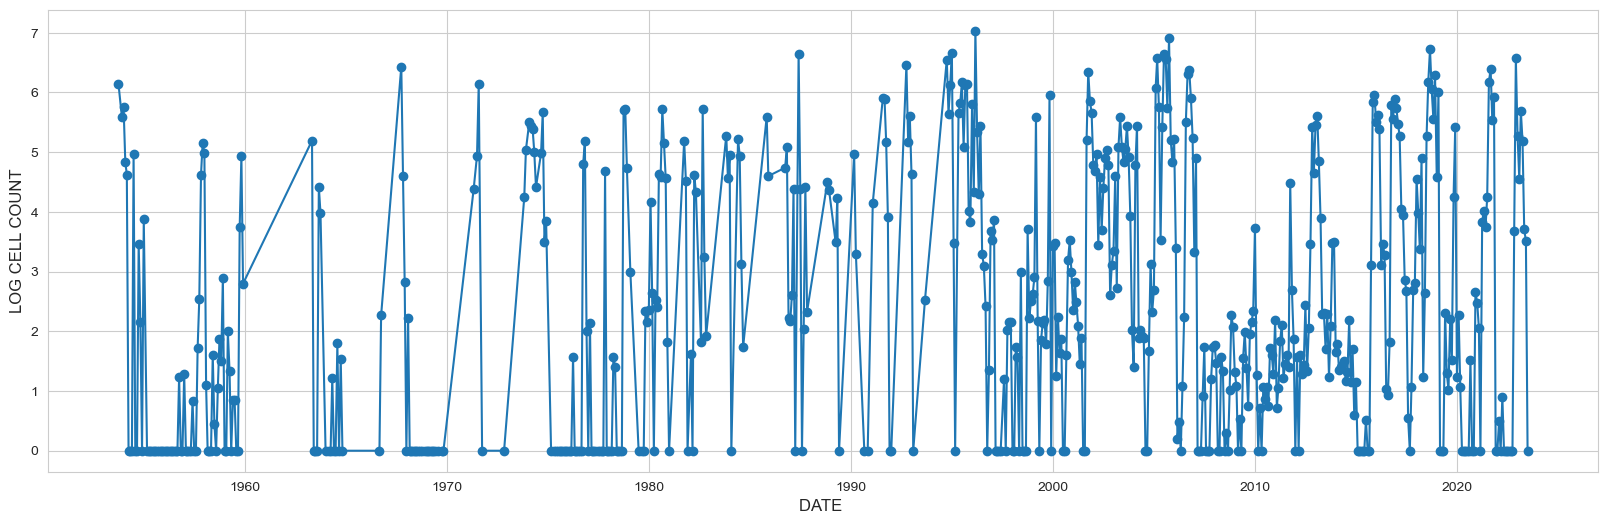

In [175]:
plt.figure(figsize=(20,6))

plt.plot(df_monthly_nona.year_month,df_monthly_nona.cellcount_log,'-o')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("DATE ", fontsize=12)
plt.ylabel("LOG CELL COUNT", fontsize=12)

plt.show()

Lets make a training and test split. I will leave `2023` data as test and the rest as training.

In [176]:
alg_train =  df_monthly_nona.loc[df_monthly_nona.year_month < datetime(2023, 1, 1)].copy()
alg_test = df_monthly_nona.drop(alg_train.index).copy()

From previous considerations we assumed we have a non-seasonal data. Moreover in this basic form I can't even see a trend, with this in mind and following lecture 6-7 we have the following baseline models:
- The average forecast
- The naive forecast

Below I will compute these baselines.

# Baselines

### The average forecast

This one basically take the average of all training data and forecast it indefinitely into the future.

In [177]:
train_avg = alg_train.cellcount_log.mean()

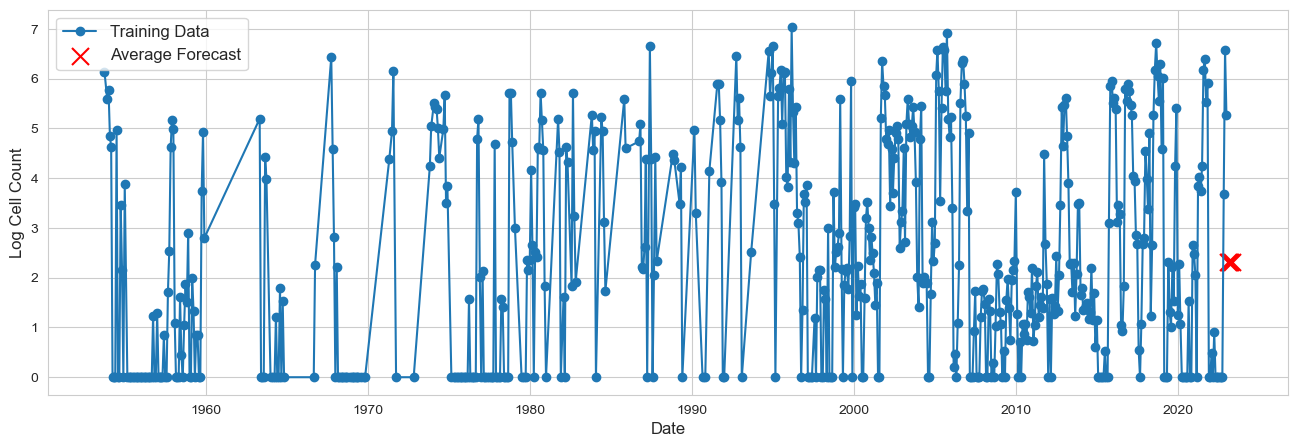

In [178]:
plt.figure(figsize=(16,5))

plt.plot(alg_train.year_month,
            alg_train.cellcount_log,
            '-o',
            label = "Training Data")

plt.scatter(pd.date_range(start =alg_train.year_month.max()+ pd.DateOffset(months=1), 
         end =alg_train.year_month.max()+ pd.DateOffset(months=4), freq ='1M'),
            train_avg*np.ones(4),
            marker='x',
            s=150,
            color='red',
            label="Average Forecast")

plt.legend(fontsize=12)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Log Cell Count", fontsize=12)

    
plt.show()

### Naive Forecast

This one just takes the last training data and predicts it indefinitely.

In [179]:
naive = alg_train.cellcount_log.values[-1]

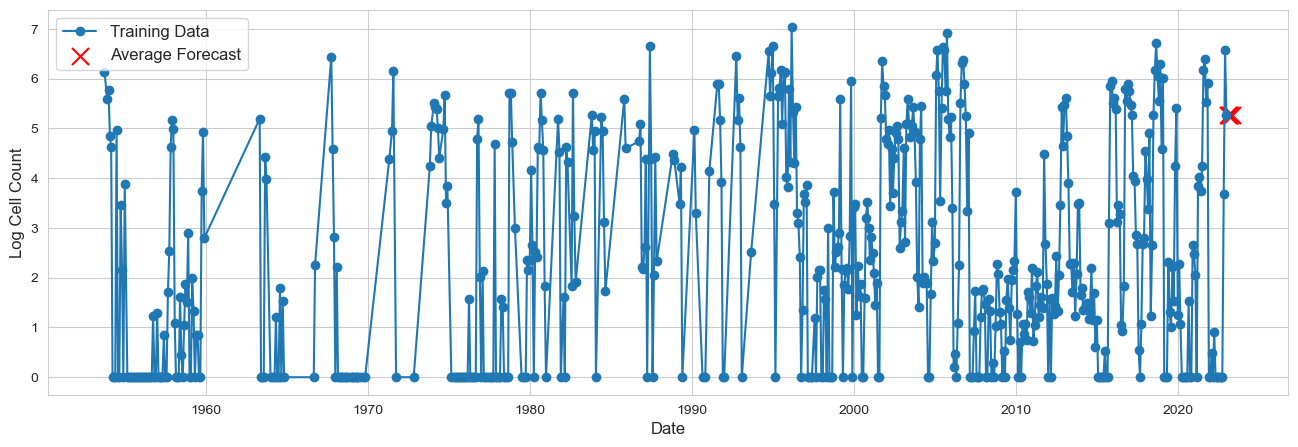

In [180]:
plt.figure(figsize=(16,5))

plt.plot(alg_train.year_month,
            alg_train.cellcount_log,
            '-o',
            label = "Training Data")

plt.scatter(pd.date_range(start =alg_train.year_month.max()+ pd.DateOffset(months=1), 
         end =alg_train.year_month.max()+ pd.DateOffset(months=4), freq ='1M'),
            naive*np.ones(4),
            marker='x',
            s=150,
            color='red',
            label="Average Forecast")

plt.legend(fontsize=12)


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Log Cell Count", fontsize=12)

    
plt.show()

Now using cross validation let us check which baseline performs better. 

In [181]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [182]:
cv = TimeSeriesSplit(10, 
                     test_size=5)

In [183]:
avg_rmses = np.zeros(10)

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.loc[train_index] #train set
    alg_ho = alg_train.loc[test_index] #holdout set
    
    tt_avg = alg_tt.cellcount_log.mean()
    
    avg_rmses[i] = np.sqrt(mean_squared_error(alg_ho.cellcount_log.values,
                                    tt_avg*np.ones(5)))
    
    i = i + 1

In [184]:
np.mean(avg_rmses)

2.2148279198075658

In [185]:
naive_rmses = np.zeros(10)

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.loc[train_index] #train set
    alg_ho = alg_train.loc[test_index] #holdout set
    
    tt_naive = alg_tt.cellcount_log.values[-1]
    
    naive_rmses[i] = np.sqrt(mean_squared_error(alg_ho.cellcount_log.values,
                                    tt_naive*np.ones(5)))
    
    i = i + 1

In [186]:
np.mean(naive_rmses)

2.2854503145622482

# Models

After checking two baselines I will try to compare the `Rolling Average`, `Exponential Smoothing` and `ARIMA` with respect to these baselines and try to see if they perform better or which `hyperparameters` to choose to make them perform better.

Below I copied the function from problem set 7, to check against the `Naive prediction`.

In [ ]:
# This function takes 3 numpy arrays as inputs.
# It returns the 
# mean absolute error of the forecast on the test set 
# relative to the
# mean absolute error of the naive forecast on the training set over an equivalent horizon.
# 
# If MASE > 1 then your forecast performs worse out of sample than naive forecast does in sample.
# If MASE < 1 then your forecast performs better out of sample than naive forecast does in sample.

def mase(y_train, y_test, y_preds):
    n = len(y_train)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom

### Rolling Average

The first model we fit is a rolling average model. Below we tune the moving average window size, $q$, to find the value that minimizes the Mean Absolute Scaled Error.

In [206]:
cv = TimeSeriesSplit(10, test_size=5)

start = 2
end = 25
ra_mase = np.zeros((10, len(range(start, end))))


i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for q in range(start, end):
        pred = alg_tt.cellcount_log[-q:].mean() * np.ones(len(alg_ho))
        
        ra_mase[i,j] = mase(alg_tt.cellcount_log.values, alg_ho.cellcount_log.values, pred)
        j = j + 1
    i = i + 1

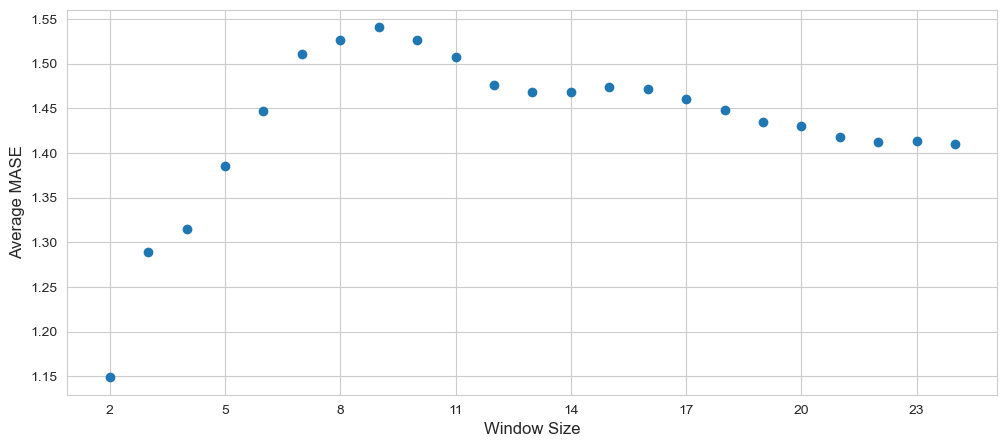

In [207]:
plt.figure(figsize=(12,5))

plt.scatter(range(start,end), np.mean(ra_mase, axis=0))

plt.xlabel("Window Size", fontsize=12)
plt.ylabel("Average MASE", fontsize=12)

plt.xticks(range(start, end, 3), fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [189]:
print("The window size that minimized the avg. cv MASE",
      "was q =", 
      range(start,end)[np.argmin(np.mean(ra_mase, axis=0))],
      "\b.",
      "It had a mean cv MASE of", 
      np.round(np.min(np.mean(ra_mase, axis=0)), 5))

The window size that minimized the avg. cv MASE was q = 2. It had a mean cv MASE of 1.1488


Note that for rolling average we have $q$=2 and MASE of 1.14 which according to the definition of MASE the model does not perform better than Naive prediction.

### Exponential Smoothing

For exponential smoothing we will do I similar hyperparameter search and scan through $\alpha=0$ to $\alpha=0.95$ and try to find the value that minimizes MASE.

In [190]:
## Importing the model from statsmodels
from statsmodels.tsa.api import SimpleExpSmoothing

In [191]:
exp_mase = np.zeros((10, len(np.arange(0, 0.95, .01))))

i = 0
for train_index, test_index in cv.split(alg_train):
    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for alpha in np.arange(0, 0.95, .01):
        exp_smooth = SimpleExpSmoothing(alg_tt.cellcount_log.values).fit(smoothing_level=alpha,optimized=False)
        exp_mase[i,j] = mase(alg_tt.cellcount_log.values, alg_ho.cellcount_log.values, exp_smooth.forecast(len(alg_ho)))
        j = j + 1
    i = i + 1

In [217]:
## This gives us the indices of the smallest
## avg cv rmse
exp_ind = np.argmin(np.mean(exp_mase, axis=0))

In [219]:
print("The alpha value that give simple exponential",
         "smoothing model with lowest avg cv rmse is",
         "alpha = ", np.arange(0, 0.95, .01)[exp_ind])

print("This model had an avg cv rmse of",
         np.round(np.mean(exp_mase, axis=0)[exp_ind],5))

The alpha value that give simple exponential smoothing model with lowest avg cv rmse is alpha =  0.93
This model had an avg cv rmse of 1.11144


In exponential smoothing we find that the $\alpha$ parameter is really close to 1, which basically says model want to get closer to the Naive baseline. Because $\alpha =1$ is where we discard all previous information.

### ARIMA

For the ARIMA models we first need to check the Autocorrelation and see if time series we work on is `stationary`. Below we checked the Autocorrelation for first for the usual data then first differenced data. This will help us to determine the $d$ value for ARIMA model.

In [196]:
import statsmodels.api as sm

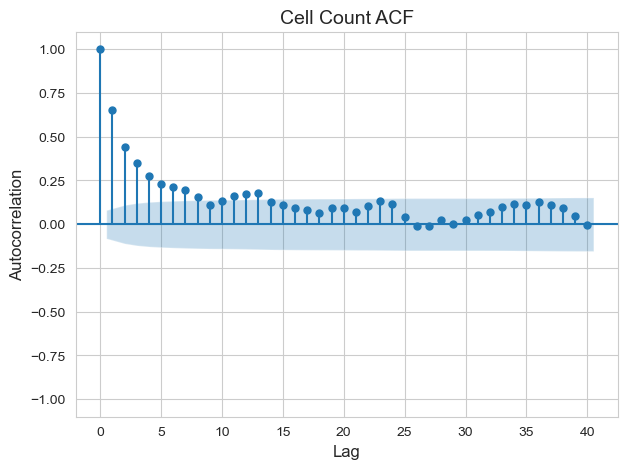

In [197]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

sm.graphics.tsa.plot_acf(alg_train.cellcount_log,
                            lags = 40,
                            ax = ax)

plt.title('Cell Count ACF', fontsize=14)
plt.ylabel("Autocorrelation", fontsize=12)
plt.xlabel("Lag", fontsize=12)

plt.ylim(-1.1,1.1)

plt.show()

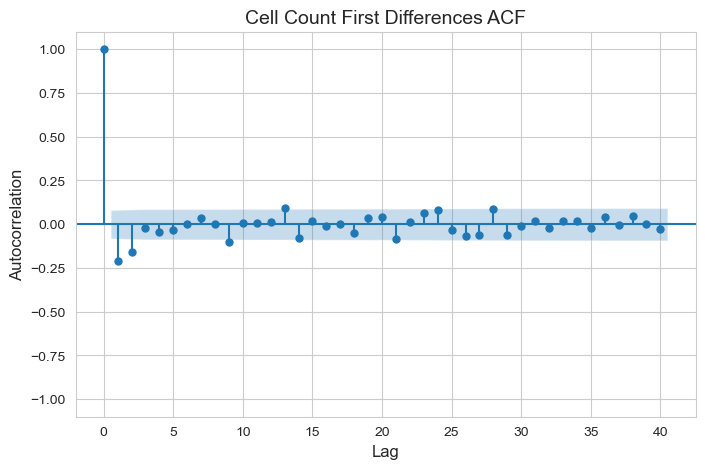

In [198]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

sm.graphics.tsa.plot_acf(alg_train.cellcount_log.diff().values[1:],
                               lags=40,
                               ax=ax)

plt.title('Cell Count First Differences ACF', fontsize=14)
plt.ylabel("Autocorrelation", fontsize=12)
plt.xlabel("Lag", fontsize=12)

plt.ylim(-1.1,1.1)

plt.show()

As seen from the above plots first differenced ACF seems to be more or less stationary at $d=1$. Setting $d=1$ we then try to find the other parameters $p, q$ for ARIMA using two different methods. First one is simply going over a range of parameters and trying to minimise MASE. 

As an alternative to cross validation MASE, another common way to select ARIMA parameters is by minimizing the [Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) on the training set.  There is a handy object called `auto_arima` from `pmdarima` which can do automatic order selection in this way.

In [220]:
from statsmodels.tsa.api import ARIMA
from pmdarima import auto_arima

Searching for $p,q$ by `MASE`

In [200]:
arima_mase = np.zeros((10, 4, 4))

i = 0
for train_index, test_index in cv.split(alg_train):

    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    
    j = 0
    for p in range(4):
        k = 0
        for q in range(4):
            arima = ARIMA(alg_tt.cellcount_log.values,
                               order=(p, 1, q)).fit()
            
            arima_mase[i,j,k] = mase(alg_tt.cellcount_log.values, alg_ho.cellcount_log.values,  arima.forecast(len(alg_ho)))
            k = k +1
        j = j + 1
    i = i +1

/Users/deniz/anaconda3/envs/jupyterthingy/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/deniz/anaconda3/envs/jupyterthingy/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/deniz/anaconda3/envs/jupyterthingy/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/deniz/anaconda3/envs/jupyterthingy/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/deniz/anaconda3/envs/jupyterthingy/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/deniz/anaconda3/envs/ju

In [201]:
arima_ind = np.unravel_index(np.argmin(np.mean(arima_mase, axis=0), axis=None), 
                             np.mean(arima_mase, axis=0).shape)
np.unravel_index(np.argmin(np.mean(arima_mase, axis=0), axis=None), 
                 np.mean(arima_mase, axis=0).shape)

(0, 0)

In [202]:
print("The parameters that give an ARIMA model",
         "with lowest avg cv mase are",
         "(p,d,q) = ( %s, %s, %s )" %(range(4)[arima_ind[0]], 1, range(4)[arima_ind[1]]))

print("This model had an avg cv mase of",
         np.round(np.mean(arima_mase, axis=0)[arima_ind],3))

The parameters that give an ARIMA model with lowest avg cv mase are (p,d,q) = ( 0, 1, 0 )
This model had an avg cv mase of 1.112


Searching $p,q$ by `AIC`

In [203]:
auto_arima(alg_train.cellcount_log.values, trace=True, max_p=8, max_q=8)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2257.085, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2358.481, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2334.671, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2315.242, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2356.482, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2255.088, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2278.297, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2253.391, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2255.161, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2310.283, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2251.581, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2313.243, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2332.671, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2253.404, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]          

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [204]:
arima_mase_auto = np.zeros((10))

i = 0
for train_index, test_index in cv.split(alg_train):

    alg_tt = alg_train.iloc[train_index]
    alg_ho = alg_train.iloc[test_index]
    arima = ARIMA(alg_tt.cellcount_log.values,
                               order=(1, 1, 1)).fit()
    arima_mase_auto[i] = mase(alg_tt.cellcount_log.values, alg_ho.cellcount_log.values,  arima.forecast(len(alg_ho)))
            
    i = i +1

In [205]:
arima_mase_auto.mean()

1.1459092424371713

As seen above the end results for parameters disagree for some reason but in anyways the MASE for them is still > 1. So they are not performing good enough. 